In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator



2024-07-05 17:27:02.750423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 17:27:02.750536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 17:27:03.048387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load data
train_df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
train_images_path = '/kaggle/input/severstal-steel-defect-detection/train_images/'

# Fill NaN values with an empty string
train_df['EncodedPixels'].fillna('', inplace=True)


/tmp/ipykernel_24/3332325952.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['EncodedPixels'].fillna('', inplace=True)


In [3]:
# Preprocess data
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))  # Reduce the image size
    image = image / 255.0
    return image


In [4]:
# Prepare images and labels
images = []
labels = []

# Create a dictionary to hold image paths and corresponding labels
image_dict = {}

for idx, row in train_df.iterrows():
    image_file = row['ImageId']
    class_id = row['ClassId'] - 1  # Classes are 1, 2, 3, 4 in the dataset
    if image_file not in image_dict:
        image_dict[image_file] = np.zeros(4)  # Initialize label array
    if row['EncodedPixels'] != '':
        image_dict[image_file][class_id] = 1  # Set the corresponding class

for image_file, label in image_dict.items():
    image_path = os.path.join(train_images_path, image_file)
    image = preprocess_image(image_path)
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)


In [5]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [6]:
# Use ImageDataGenerator for batch processing
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [7]:
# Build the model using transfer learning
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')  # Using sigmoid for multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Train the model
history = model.fit(train_generator, epochs=25, validation_data=val_generator)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/167 ━━━━━━━━━━━━━━━━━━━━ 4:16:13 93s/step - accuracy: 0.2812 - loss: 0.6923

I0000 00:00:1720200648.213741      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720200648.315468      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/167 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.6887 - loss: 0.4100

W0000 00:00:1720200705.657967      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7464 - loss: 0.3262

W0000 00:00:1720200717.684584      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 169s 460ms/step - accuracy: 0.7468 - loss: 0.3255 - val_accuracy: 0.7489 - val_loss: 31.8547
Epoch 2/25
  1/167 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.8750 - loss: 0.2681

W0000 00:00:1720200724.751833      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8389 - loss: 0.1940 - val_accuracy: 0.7489 - val_loss: 0.4932
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8516 - loss: 0.1673 - val_accuracy: 0.7106 - val_loss: 0.4743
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8709 - loss: 0.1429 - val_accuracy: 0.7511 - val_loss: 1.2429
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8843 - loss: 0.1353 - val_accuracy: 0.8448 - val_loss: 0.2345
Epoch 6/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8849 - loss: 0.1288 - val_accuracy: 0.8291 - val_loss: 0.2203
Epoch 7/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8949 - loss: 0.1138 - val_accuracy: 0.8456 - val_loss: 0.2006
Epoch 8/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8964 - loss: 0.1174 - val_accuracy: 0.8576 - val_loss: 0.1660
Epoch 9/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9004 - loss: 0.1070 - val_accuracy: 0.69

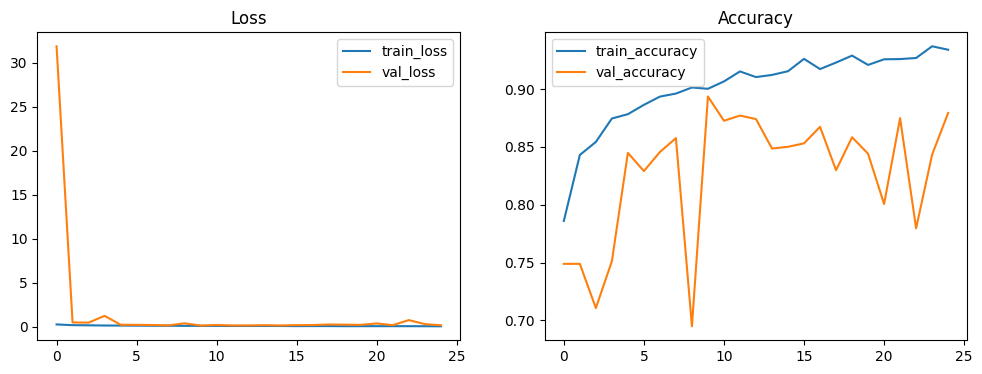

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


13/42 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1720200953.382931      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step


W0000 00:00:1720200959.160871      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


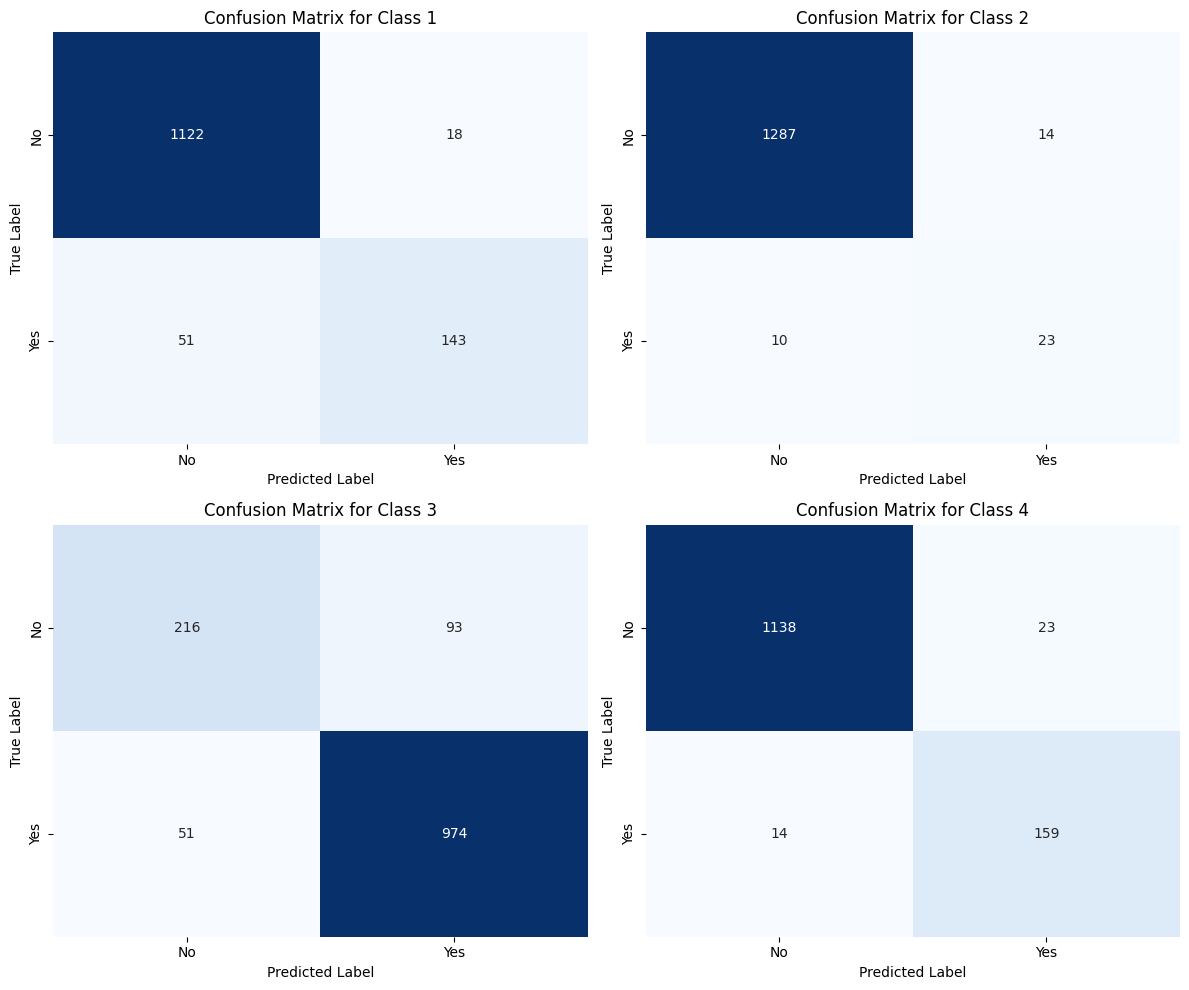

              precision    recall  f1-score   support

     Class 1       0.89      0.74      0.81       194
     Class 2       0.62      0.70      0.66        33
     Class 3       0.91      0.95      0.93      1025
     Class 4       0.87      0.92      0.90       173

   micro avg       0.90      0.91      0.90      1425
   macro avg       0.82      0.83      0.82      1425
weighted avg       0.90      0.91      0.90      1425
 samples avg       0.91      0.92      0.91      1425



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Confusion Matrix and Classification Report
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

conf_matrix = multilabel_confusion_matrix(y_val, y_pred)

# Visualize Confusion Matrices with Heatmap
def plot_confusion_matrices(conf_matrix):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    class_names = [f"Class {i+1}" for i in range(4)]

    for i, ax in enumerate(axes):
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
        ax.set_title(f'Confusion Matrix for {class_names[i]}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_pred, target_names=[f"Class {i+1}" for i in range(4)])
print(class_report)


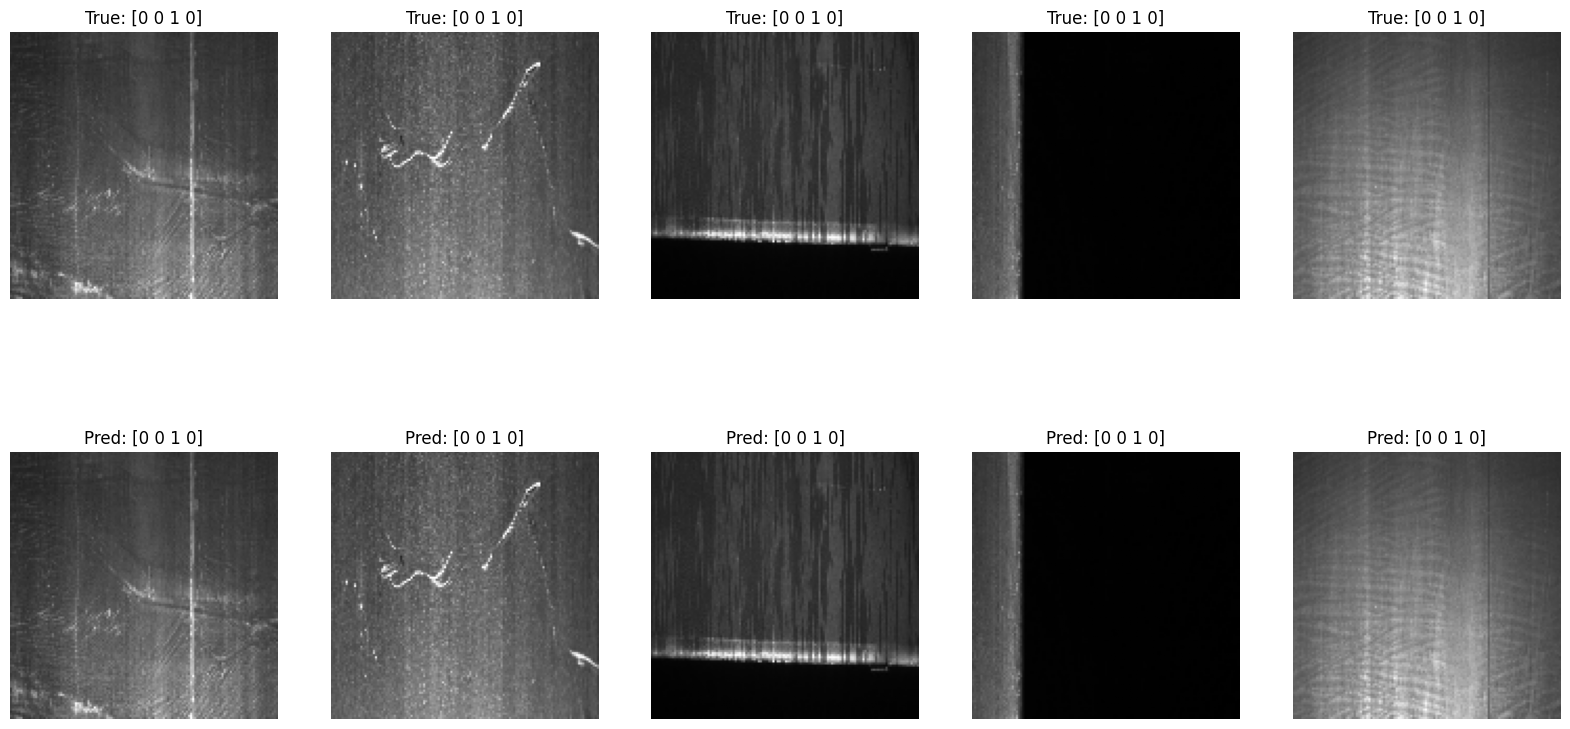

In [11]:
# Visualize some predictions
def plot_predictions(images, true_labels, pred_labels, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i].astype(int)}")
        plt.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(images[i])
        plt.title(f"Pred: {pred_labels[i].astype(int)}")
        plt.axis("off")

indices = np.random.choice(len(X_val), 5, replace=False)
plot_predictions(X_val[indices], y_val[indices], y_pred[indices])


In [12]:
# Save the model
model.save('steel_defect_detection_model.h5')
print("Model saved successfully.")


Model saved successfully.
